In [1]:
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.gmm import IV2SLS
import linearmodels

In [2]:
## a small smaple to show how beta estimation would be biased when only x has measurement errors

In [3]:
ols_model = LinearRegression()

In [4]:
x = np.random.rand(1000)
x = pd.DataFrame(x)
x.T

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.656054,0.426671,0.081799,0.844085,0.631949,0.647178,0.826129,0.43984,0.946345,0.635904,...,0.419016,0.351787,0.171552,0.225785,0.180701,0.974363,0.792314,0.201064,0.305549,0.11322


In [5]:
errs = pd.DataFrame(np.random.normal(0,0.5,len(x)))
errs.T

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.349111,0.835808,0.231568,-0.107457,0.204855,-0.554045,-0.346018,0.081719,-0.580562,-0.060009,...,-0.016302,-0.489519,-0.250198,-0.662995,-0.595779,0.446059,-0.180388,0.451877,0.377228,0.353942


In [6]:
x_err = x+errs
x_err.T

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.306943,1.262479,0.313367,0.736628,0.836803,0.093133,0.480111,0.521559,0.365783,0.575895,...,0.402714,-0.137731,-0.078646,-0.437209,-0.415077,1.420422,0.611926,0.652941,0.682777,0.467162


In [7]:
beta = 1

In [8]:
y = pd.DataFrame(x*beta)
# +pd.DataFrame(np.random.normal(0,1,1000))
y

,0
0,0.656054
1,0.426671
2,0.081799
3,0.844085
4,0.631949
...,...
995,0.974363
996,0.792314
997,0.201064
998,0.305549


In [9]:
res = ols_model.fit(x_err,y)
res.coef_

array([[0.2544962]])

In [10]:
ld = x.var()/(x.var()+errs.var())
ld*beta

0    0.248994
dtype: float64

In [11]:
## Calculate the bias of using OLS due to the measurement errors of explanatory variables 
res.coef_-beta

array([[-0.7455038]])

In [12]:
(ld-1)*beta

0   -0.751006
dtype: float64

## CAPM Simulation_South Africa

In [13]:
## To evaluate the samll sample properties of the IV method, a battery of simulations are conducted using the parameters
## matched to real data.

In [14]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [15]:
df_MR = pd.read_csv('df_MR.csv')

In [16]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [17]:
df_MR.set_index('Dates',inplace=True)

In [18]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [19]:
df_Ex_SR = df_SR-df_RF.values

In [20]:
df_Ex_SR = df_Ex_SR.loc[df_MR.index,:]

In [21]:
ols_model = LinearRegression()

In [22]:
## For each stock, we fit market model regressions to esimate constant betas and residual return standard deviation;
## Then we match the simulation paramters (mean&std_dev) to the distribution of these parametes in the real data.

In [23]:
# Constant beta estimations without rolling windows
all_betas = []
all_sigmas = []

betas = []
sigmas = []
labels = []
# j is cross-sectional stock name
for j in tqdm(df_Ex_SR.columns):
    df_index = df_Ex_SR.loc[:, j].dropna().index

    if len(df_index) != 0:
        #         lag = int(4*((len(df_Ex_SR.loc[df_index,j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index, j].values.astype(
            np.float64), sm.add_constant(df_MR.loc[df_index, :].values.astype(np.float64)))
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        res = ols.fit()
        b = list(res.params)
        s = np.std(res.resid)
        betas.append(b)
        sigmas.append(s)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_sigmas.append(pd.DataFrame(sigmas))

100%|██████████| 836/836 [00:01<00:00, 492.74it/s]


In [24]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas = df_betas[(np.abs((df_betas-df_betas.mean())/df_betas.std()) <= 3).all(axis=1)]
df_betas

,Intercepts,MKT
Stocks,,
ABC.SJ.Equity,-0.000527,0.012906
ABI.SJ.Equity,-0.000128,0.065382
ABK.SJ.Equity,-0.001182,0.182993
ABR.SJ.Equity,-0.001066,-0.022444
ABU.SJ.Equity,-0.000235,0.010576
...,...,...
ZPT.SJ.Equity,-0.001798,0.079832
ZRNHDG.SJ.Equity,-0.000197,0.012835
ZRNPLY.SJ.Equity,-0.000181,0.000153


In [25]:
## The following is residual return standard deviations
df_sigmas = pd.concat([all_sigmas[0], pd.DataFrame(labels)], axis = 1)
df_sigmas.columns = ['sigmas','Stocks']
df_sigmas = df_sigmas.set_index('Stocks')
df_sigmas = df_sigmas[(np.abs((df_sigmas-df_sigmas.mean())/df_sigmas.std()) <= 3).all(axis=1)]
df_sigmas

,sigmas
Stocks,
ABC.SJ.Equity,0.019822
ABI.SJ.Equity,0.005701
ABK.SJ.Equity,0.044608
ABR.SJ.Equity,0.025737
ABU.SJ.Equity,0.008763
...,...
ZGOVI.SJ.Equity,0.002538
ZRNHDG.SJ.Equity,0.002140
ZRNPLY.SJ.Equity,0.000040


In [26]:
## We conduct simulations with the cross-sectional size of N=819 stocks. We randomly generat daily returns using the following procedures:
## Step-1: For each stock, we randomly generate a beta and a standard deviations of return residuals from normal distributions.

In [27]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_betas = np.mean(df_betas.iloc[:,1])
sd_all_betas = np.std(df_betas.iloc[:,1])
print(m_all_betas, sd_all_betas)

0.14539150624467168 0.2039198365818857


In [28]:
## ** the mean and standard deviation of simulated beta/residuals the same as the real betas'/residuals' 
m_all_sigmas = np.mean(df_sigmas.iloc[:,0].astype('float64'))
sd_all_sigmas = np.std(df_sigmas.iloc[:,0].astype('float64'))
print(m_all_sigmas, sd_all_sigmas)

0.016140515602232015 0.013898846370626751


## beta,i and res_sigma,i are fixed through 100 repetitions

In [191]:
# How many stocks in the simulation sample on cross-sectional scale
N = 1000

In [192]:
sim_betas_tmp = []
sim_betas_tmp.append(np.random.normal(loc = m_all_betas,scale = sd_all_betas, size= N ))
np.mean(sim_betas_tmp), np.std(sim_betas_tmp)

(0.13981810255514227, 0.1999763315620122)

In [193]:
sim_betas = pd.DataFrame(sim_betas_tmp)
sim_betas

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.387548,0.480773,0.494798,0.136787,0.158604,0.330199,-0.017252,0.310704,-0.089353,0.388987,...,-0.019848,0.14055,0.113615,0.016385,0.002108,0.163657,0.251011,0.414552,0.408261,0.235752


In [194]:
sim_sigmas_tmp = []
sim_sigmas_tmp.append(np.random.normal(loc = m_all_sigmas,scale = sd_all_sigmas, size= N ))
np.mean(sim_sigmas_tmp), np.std(sim_sigmas_tmp)

(0.015587676356354024, 0.0135036604364964)

In [195]:
sim_sig_res = pd.DataFrame(sim_sigmas_tmp).abs()
sim_sig_res

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.019566,0.014095,0.0351,0.031915,0.003668,0.001954,0.013674,0.030339,0.026806,0.015004,...,0.030236,0.002946,0.007238,0.062836,0.00636,0.024188,0.022769,0.005729,0.024379,0.045889


In [196]:
## Step-2: For each day, we randomly draw market excess return from a normal distribution with mean and standard deviation
## equal to the sample mean and standard deviation from the data

## sim_MKT, sim_SR and res_return are changable through 100 repetitions

In [197]:
mean_MKT = np.mean(df_MR.iloc[:,0])
sd_MKT = np.std(df_MR.iloc[:,0])
print(mean_MKT, sd_MKT)

0.0002807670182166827 0.011549088535812713


In [198]:
## It's important to make sure that np.mean(sim_MKT_tmp) is precisely equal to mean_MKT, otherwise the gap between 
## ex-ante and ex-post biases will be significant

In [199]:
sim_MKT_tmp = []
sim_MKT_tmp.append(np.random.normal(loc = mean_MKT,scale = sd_MKT, size= len(df_MR)))
print(np.mean(sim_MKT_tmp), np.std(sim_MKT_tmp))

0.00027231246421986457 0.011521353736816287


In [200]:
sim_MKT = pd.DataFrame(sim_MKT_tmp).T
sim_MKT.index = df_MR.index
sim_MKT.columns = ['RM-RF']
sim_MKT

,RM-RF
Dates,
2000-01-05,0.006304
2000-01-06,0.014800
2000-01-07,-0.008547
2000-01-10,-0.000302
2000-01-11,0.011110
...,...
2019-12-25,0.007498
2019-12-26,0.008927
2019-12-27,-0.008720


In [201]:
## Step-3: For each stock, we then randomly generate daily residual return from a normal distribution with mean zero and
## standard deviation equal to the value generate in step-1, i.e. sim_sigmas

In [202]:
res_return = pd.DataFrame(np.zeros((len(sim_MKT), len(sim_sig_res.columns))))
# d = pd.DataFrame(np.zeros((N_rows, N_cols)))
for j in range(len(sim_sig_res.columns)):
    res_return.iloc[:,j] = np.random.normal(loc = 0,scale = sim_sig_res[j], size= len(sim_MKT))
res_return

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.030820,0.002713,0.036237,-0.018312,0.004832,-0.001920,-0.019875,-0.027388,0.059705,0.003430,...,-0.007543,-0.001647,0.007421,-0.090411,0.006404,0.010487,-0.022333,-0.001387,0.003733,-0.059312
1,0.025226,-0.006654,-0.035675,0.064918,-0.004278,-0.003773,0.010607,0.017992,0.019327,0.011759,...,0.043005,-0.002609,-0.004713,0.022278,0.011043,0.002327,-0.009048,0.003553,-0.019884,0.037710
2,0.027126,0.015413,-0.029424,-0.008093,-0.000499,0.002423,0.037981,0.032403,-0.007880,0.003419,...,0.001907,0.000945,-0.004896,-0.010787,-0.009266,0.013087,-0.014094,-0.001715,-0.027467,0.039340
3,0.001698,-0.005519,-0.003154,0.019952,-0.001920,0.000402,-0.014385,-0.010617,-0.041828,0.000895,...,0.079819,0.001322,0.010979,0.102737,-0.022035,0.006141,-0.006395,0.000061,-0.029091,-0.004290
4,-0.008602,-0.032111,0.027150,-0.008407,-0.007927,-0.000238,-0.023536,-0.038023,0.013391,-0.018937,...,0.008035,0.002651,-0.005031,-0.005912,0.007924,0.013048,-0.004752,0.002238,0.022047,0.051432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5210,-0.001239,0.015274,-0.042968,-0.062109,0.005221,-0.000867,-0.003955,0.020057,-0.011184,0.001975,...,-0.015271,0.007426,-0.007105,-0.044307,0.002102,0.017021,-0.029249,-0.000696,0.011833,-0.080076
5211,0.004844,0.041635,-0.001370,-0.021754,0.002643,-0.001007,0.004330,0.013266,0.016720,-0.007342,...,0.032382,-0.002562,0.001737,0.017947,0.011029,0.028462,-0.017336,-0.007126,0.000224,0.038307
5212,0.011716,-0.011294,-0.027140,0.025996,0.005401,-0.001062,0.003118,-0.040681,-0.011364,0.016705,...,0.010044,-0.003253,-0.007608,-0.054937,0.001705,0.026156,0.021862,0.000784,-0.011998,-0.032801
5213,0.034241,-0.006711,0.089602,0.018433,-0.002423,0.005608,0.025254,-0.030290,0.012276,-0.000592,...,0.032809,-0.004821,-0.001167,0.076516,0.008056,0.008396,0.004686,0.000669,-0.031386,-0.024981


In [203]:
## Step-4: For stock i, we compute its excess return as beta,i*MKT,t + episiloni,,t

In [204]:
errors = []
errors.append(np.random.normal(loc = 0,scale = 0.01, size= len(df_MR)))
print(np.mean(errors), np.std(errors))

8.048596892812582e-05 0.010139986115851892


In [205]:
errors = pd.DataFrame(errors).T
errors.index = df_MR.index
errors

,0
Dates,
2000-01-05,-0.006613
2000-01-06,-0.001311
2000-01-07,0.011814
2000-01-10,0.001957
2000-01-11,-0.002111
...,...
2019-12-25,0.003290
2019-12-26,-0.009541
2019-12-27,0.000204


In [206]:
B_sim_MKT = sim_MKT + errors.values
B_sim_MKT

,RM-RF
Dates,
2000-01-05,-0.000310
2000-01-06,0.013489
2000-01-07,0.003267
2000-01-10,0.001655
2000-01-11,0.008999
...,...
2019-12-25,0.010788
2019-12-26,-0.000615
2019-12-27,-0.008516


In [207]:
## y = beta*x + epsilon
sim_SR = (np.mat(sim_MKT.iloc[:,0]).T*np.mat(sim_betas.iloc[0,:].values)) + res_return
sim_SR = pd.DataFrame(sim_SR)
sim_SR.index = df_Ex_SR.index
sim_SR

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.028377,0.005743,0.039356,-0.017450,0.005831,0.000162,-0.019984,-0.025429,0.059142,0.005882,...,-0.007668,-0.000761,0.008137,-0.090308,0.006417,0.011519,-0.020751,0.001226,0.006306,-0.057826
2000-01-06,0.030962,0.000462,-0.028352,0.066943,-0.001931,0.001114,0.010352,0.022590,0.018005,0.017516,...,0.042712,-0.000529,-0.003032,0.022521,0.011074,0.004749,-0.005333,0.009688,-0.013841,0.041199
2000-01-07,0.023813,0.011304,-0.033653,-0.009262,-0.001855,-0.000399,0.038128,0.029747,-0.007116,0.000095,...,0.002077,-0.000257,-0.005867,-0.010927,-0.009284,0.011688,-0.016240,-0.005258,-0.030957,0.037325
2000-01-10,0.001581,-0.005664,-0.003304,0.019910,-0.001968,0.000302,-0.014380,-0.010711,-0.041801,0.000778,...,0.079825,0.001279,0.010945,0.102732,-0.022035,0.006091,-0.006471,-0.000064,-0.029215,-0.004361
2000-01-11,-0.004296,-0.026769,0.032648,-0.006888,-0.006165,0.003431,-0.023728,-0.034571,0.012398,-0.014615,...,0.007814,0.004212,-0.003769,-0.005730,0.007947,0.014867,-0.001963,0.006844,0.026583,0.054051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.001667,0.018879,-0.039258,-0.061083,0.006411,0.001609,-0.004084,0.022386,-0.011854,0.004892,...,-0.015419,0.008480,-0.006253,-0.044184,0.002118,0.018248,-0.027367,0.002413,0.014895,-0.078308
2019-12-26,0.008303,0.045927,0.003047,-0.020533,0.004059,0.001941,0.004176,0.016039,0.015922,-0.003870,...,0.032205,-0.001307,0.002751,0.018094,0.011047,0.029923,-0.015095,-0.003425,0.003869,0.040412
2019-12-27,0.008337,-0.015487,-0.031455,0.024804,0.004018,-0.003941,0.003268,-0.043390,-0.010585,0.013313,...,0.010217,-0.004479,-0.008599,-0.055080,0.001686,0.024729,0.019673,-0.002831,-0.015558,-0.034856


In [208]:
from datetime import datetime
months = []
periods = int(len(sim_SR)/21)+1
mons = pd.date_range(start=sim_SR.index[0], periods = periods, freq='M').astype(str).str[:7]
for i in range(periods):
    m = mons[i]
    months.append(np.repeat(m,21))

In [209]:
## sum daily stock and factor log returns to compute corresponding monthly returns
m_sim_SR = sim_SR
m_sim_SR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_SR = m_sim_SR.groupby('month').sum()
sim_SR = sim_SR.drop(['month'], axis = 1)
m_sim_SR = m_sim_SR.iloc[:-1,:]
m_sim_SR

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
month,,,,,,,,,,,,,,,,,,,,,
2000-01,0.089586,-0.005602,0.062404,-0.080348,-0.016224,-0.008926,-0.031452,-0.007820,0.084993,-0.010204,...,0.302544,0.010243,0.000719,-0.156331,-0.011726,-0.171357,0.089938,-0.003285,-0.028080,0.028204
2000-02,-0.154715,0.045629,-0.085807,0.108615,0.012700,-0.013724,0.097343,-0.023515,0.055348,0.016638,...,0.049239,-0.018896,0.001604,0.151487,-0.002036,-0.009848,-0.066161,-0.022210,0.041305,0.018577
2000-03,0.192321,0.009748,0.077451,0.026836,0.009877,0.008977,0.090131,-0.089386,0.007376,0.095124,...,0.062434,-0.004736,0.053695,-0.050266,-0.003665,0.106386,0.030319,0.017993,-0.028942,-0.009700
2000-04,0.251627,0.224314,0.251509,0.202958,0.015710,0.059554,-0.068817,-0.011910,-0.012476,0.170084,...,0.168083,0.016414,0.053702,-0.117020,-0.005135,0.026126,0.053653,0.064739,0.257124,0.212230
2000-05,0.044646,0.020731,-0.307735,-0.292422,-0.018037,-0.004266,0.034039,-0.089477,0.117354,-0.153990,...,-0.030311,-0.011444,-0.048049,0.251840,0.015665,0.067529,-0.153366,-0.028618,-0.015405,0.150624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04,-0.095563,-0.092584,-0.307126,-0.109211,-0.028093,-0.048779,-0.011258,-0.165528,-0.117966,-0.185227,...,-0.239123,-0.037205,0.016251,0.316818,0.029300,0.009701,-0.029130,-0.058883,-0.041424,-0.206827
2020-05,0.073477,0.059318,0.065162,0.100564,0.052471,0.005110,-0.172738,-0.163554,-0.164166,0.144684,...,0.065036,0.001054,0.005653,-0.245666,-0.002091,-0.108642,-0.131118,0.057151,-0.047235,-0.129492
2020-06,-0.047724,0.069287,0.009384,0.134855,0.000093,0.000088,0.062051,-0.169868,0.032016,-0.065046,...,-0.034129,0.009079,-0.000087,0.057710,-0.015992,0.068660,-0.193115,-0.003449,0.082583,-0.140512


In [210]:
B_m_sim_MKT = B_sim_MKT
B_m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
B_m_sim_MKT = B_m_sim_MKT.groupby('month').sum()
B_sim_MKT = B_sim_MKT.drop(['month'], axis = 1)
B_m_sim_MKT = B_m_sim_MKT.iloc[:-1,:]
B_m_sim_MKT

,RM-RF
month,
2000-01,-0.001925
2000-02,-0.009011
2000-03,0.028087
2000-04,0.206904
2000-05,-0.031826
...,...
2020-04,-0.124212
2020-05,0.006677
2020-06,-0.057857


In [211]:
m_sim_MKT = sim_MKT
m_sim_MKT['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_sim_MKT = m_sim_MKT.groupby('month').sum()
sim_MKT = sim_MKT.drop(['month'], axis = 1)
m_sim_MKT = m_sim_MKT.iloc[:-1,:]
m_sim_MKT

,RM-RF
month,
2000-01,0.002517
2000-02,0.005993
2000-03,0.027110
2000-04,0.171663
2000-05,-0.044537
...,...
2020-04,-0.139342
2020-05,0.051439
2020-06,0.001578


In [212]:
## Step-5: For the first-stage regression in the simulation, we estimate betas using time series regression (OLS&IV)

### OLS (without rolling window)

In [213]:
# use the factor model in linearmodel module, however, this function would not allow for time-varying beta meaning that
# the result of this FM two-step regression would be the same as cross-sectional regression.
from linearmodels.asset_pricing.model import LinearFactorModel
model_ols = LinearFactorModel(portfolios=sim_SR, factors= B_sim_MKT, risk_free = None)
res_ols = model_ols.fit()
res_ols.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                      LinearFactorModel Estimation Summary                      
================================================================================
No. Test Portfolios:               1000   R-squared:                      0.0100
No. Factors:                          1   J-statistic:                    1185.1
No. Observations:                  5215   P-value                         0.0000
Date:                  Mon, Apr 11 2022   Distribution:                chi2(999)
Time:                          00:11:23                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
RM-RF          0.0004     0.0003     1.4403     0.1498     -0.0001      0.0010
==============================================================================

Covariance estimator:
HeteroskedasticCovariance
See full_summary for complete results
"""

In [214]:
print("ex-ante bias(%):" + str(((res_ols.risk_premia-mean_MKT)/mean_MKT*100).values))
print("ex-post bias(%):" + str(((res_ols.risk_premia-np.mean(sim_MKT))/np.mean(sim_MKT)*100).values))

ex-ante bias(%):[47.85409991]
ex-post bias(%):[52.44456357]


In [215]:
# from linearmodels.asset_pricing import LinearFactorModelGMM
# model_GMM = LinearFactorModelGMM(portfolios=sim_SR, factors= sim_MKT, risk_free = None)
# res_GMM = model_GMM.fit()
# res_GMM

## OLS (Time-varying Betas)

In [302]:
# how many years in the rolling window periods
n = 3

In [303]:
holding = 21 # 1 month
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 756


In [304]:
all_betas = []
all_resids = []
# i is time in periods
for i in tqdm(range(periods)):

    B_sim_MKT_tmp = B_sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    
    betas = []
    resids = []
    # j is cross-sectional stock name
    for j in sim_SR.columns:      
#         lag = int(4*((len(sim_SR.loc[:,j]))/100)**(1/9))
        OLS = sm.OLS(sim_SR_tmp.loc[:,j].values.astype(np.float64), sm.add_constant(B_sim_MKT_tmp.values.astype(np.float64)))
        res = OLS.fit()
#         res = ols.fit(cov_type='HAC',cov_kwds={'maxlags':lag})
        b = list(res.params)
        r = list(res.resid)
        betas.append(b)
        resids.append(r)
        
    df_betas = pd.DataFrame(betas).rename(columns={0:'Intercepts',1:'MKT'})
    all_betas.append(df_betas)
    all_resids.append(pd.DataFrame(resids))   

100%|██████████| 211/211 [01:40<00:00,  2.09it/s]


In [305]:
all_betas[0]

,Intercepts,MKT
0,0.000836,0.224297
1,0.000098,0.234573
2,0.000999,0.365729
3,-0.000531,0.023990
4,0.000065,0.083862
...,...,...
995,0.000428,0.093561
996,0.000349,0.150812
997,-0.000414,0.216163
998,0.000491,0.261059


In [307]:
corr_betas_true = []

for i in range(len(all_betas)):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_betas_true.append(corr)

print(np.mean(corr_betas_true), stats.ttest_1samp(corr_betas_true, 0.0)[0])

0.9160433024987291 1449.0874823151685


In [308]:
# sum daily market return to compute corresponding monthly returns
m_MR = df_MR
m_MR['month'] = np.array(flatten(months)[0:len(sim_SR)], dtype = str)
m_MR = m_MR.groupby('month').sum()
df_MR = df_MR.drop(['month'], axis = 1)
m_MR = m_MR.iloc[:-1,:]
m_MR

,MR_RF
month,
2000-01,0.0154
2000-02,-0.0955
2000-03,-0.0024
2000-04,-0.0693
2000-05,-0.0119
...,...
2020-04,-0.0695
2020-05,0.0382
2020-06,-0.0010


In [309]:
holding = 1 # 1 month
rollingW = holding *n*12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 36


In [310]:
all_lambdas_OLS = []
all_resids_OLS = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):   
    i = int(index_times.index(k)/holding)
    OLS = sm.OLS(m_sim_SR_tmp_T.loc[:,k], sm.add_constant(all_betas[i].loc[:,"MKT"].astype(np.float64)))
    res = OLS.fit()
    l = list(res.params)
    r = list(res.resid)
    lambdas.append(l)
    resids.append(r)
        
all_lambdas_OLS.append(pd.DataFrame(lambdas))
all_resids_OLS.append(pd.DataFrame(resids))

100%|██████████| 211/211 [00:00<00:00, 695.89it/s]


In [311]:
all_lambdas_OLS[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.005361,0.017083
1,-0.001148,-0.135118
2,0.002123,0.066043
3,0.002359,0.032737
4,-0.002241,0.100875
...,...,...
206,-0.005171,-0.033630
207,-0.003044,-0.235743
208,-0.000216,0.103819
209,0.000224,-0.009182


In [312]:
all_resids_OLS = pd.DataFrame(all_resids_OLS[0].T)
all_resids_OLS

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-0.194877,-0.076672,0.005055,-0.025742,0.094274,0.029802,0.021925,-0.071114,0.097342,-0.074629,...,-0.061227,-0.061432,0.116925,0.062965,-0.012804,-0.269390,-0.044672,0.052328,-0.045995,0.078226
1,0.008496,0.033868,-0.045974,0.030630,0.080499,-0.024686,0.038661,0.072029,-0.034351,0.059874,...,-0.109923,-0.080814,-0.023898,0.085921,-0.022121,0.012905,-0.026357,0.030451,0.071706,-0.099145
2,0.082726,0.014141,-0.292801,0.141996,0.141013,-0.080211,0.349625,-0.103427,0.073344,0.013845,...,-0.201710,0.273610,0.413801,-0.275912,-0.211145,-0.120516,-0.212822,0.025965,0.012605,0.035992
3,0.008278,-0.110956,0.181256,0.100636,0.179839,0.079902,-0.012807,-0.171089,0.042698,-0.175218,...,0.100577,0.059163,-0.144197,0.156269,-0.270311,-0.133741,-0.113335,0.104723,0.134272,-0.033615
4,-0.014342,0.000571,-0.005512,0.005177,0.007844,0.003462,-0.025424,0.020334,-0.002549,0.003099,...,-0.041231,0.011655,0.009912,-0.014021,-0.024331,-0.031144,-0.003603,0.043068,0.000740,0.017006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.017087,-0.155602,-0.028926,0.108785,0.152891,-0.180622,-0.048012,-0.097135,-0.054607,-0.048672,...,-0.216894,0.162430,0.096677,0.025741,-0.166518,-0.034869,0.030040,-0.115984,0.069119,-0.010575
996,0.090983,0.196225,0.002999,0.144294,-0.063519,0.231153,-0.175840,-0.133915,0.005034,-0.189028,...,0.189629,-0.072362,0.004572,-0.103120,-0.063425,-0.158312,0.016662,-0.146110,-0.192080,0.053724
997,0.013577,0.002072,0.001504,-0.035718,0.061780,0.020776,-0.015501,-0.012176,-0.039879,0.020282,...,-0.001324,-0.048228,-0.004532,-0.036858,-0.023762,0.004545,0.000487,0.032534,-0.001442,0.007085
998,0.063376,0.155851,0.025908,-0.160432,-0.250169,-0.071376,0.006989,-0.048867,-0.082160,-0.169089,...,-0.066481,0.086241,0.092428,-0.002076,-0.038508,-0.115181,0.027582,-0.077971,0.085032,0.064501


In [313]:
stats.ttest_1samp(all_lambdas_OLS[0], 0.0)

Ttest_1sampResult(statistic=array([1.82188093, 0.45921083]), pvalue=array([0.06989562, 0.64655775]))

In [314]:
## ***Risk Premium estimate for one simulation
np.mean(all_lambdas_OLS[0].iloc[:,1]) # simulation market premium
## ***Corresponding true simulation parameters, 0.0002807670182166827 is our true daily market risk premium, i.e. 0.07075328859060404 per annum
np.mean(m_MR) #true market premium
print(np.mean(m_MR.values), np.mean(all_lambdas_OLS[0].iloc[:,1]))

0.005930241935483869 0.002740829087711753


In [315]:
# Test whether the betas in FM-2 is endougenous

In [316]:
corr_betas_res = []

for i in range(np.shape(all_resids_OLS)[1]):
    corr = stats.pearsonr(all_betas[i].MKT.values.astype(np.float64).flatten(),all_resids_OLS.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_res.append(corr)

print(np.mean(corr_betas_res), "x is Endogenous" if np.mean(corr_betas_res).round(10)!=0 else "x is Exogenous")

4.8002922726822664e-18 x is Exogenous


In [317]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [318]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_OLS[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))


ex-ante bias(%): -53.78217081984668
ex-post bias(%): -51.80207747636256


In [319]:
## The Ex-ante RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.10098285708460379

In [320]:
## The Ex-post RMSE
diff = all_lambdas_OLS[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.10461644737149806

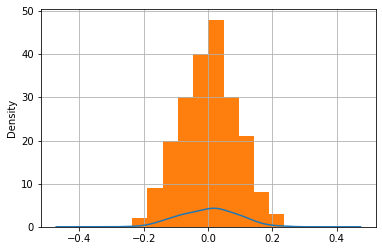

In [321]:
all_lambdas_OLS[0].iloc[:,1].plot(kind='density')
all_lambdas_OLS[0].iloc[:,1].hist()
plt.show()

## IV(Time-varying Betas)

In [322]:
holding = 21
rollingW = holding * n *12
lens = len(sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(rollingW, periods)

756 211


In [323]:
all_betas_ev = []
all_betas_iv = []

# i is time in periods
for i in tqdm(range(periods)):

    B_sim_MKT_tmp = B_sim_MKT.iloc[i*holding:i*holding+rollingW,:]
    sim_SR_tmp = sim_SR.iloc[i*holding:i*holding+rollingW,:]
    

    if (i + 1) % 2 == 1:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,B_sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is cross-sectional stock label
        for j in sim_SR.columns:
            df_index = rw_odd.index
            b = list(ols_model.fit(B_sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)
        
        rw_even = pd.DataFrame()         
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,B_sim_MKT_tmp.iloc[21*k:21*(k+1),:]])
        
        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index   
            b = list(ols_model.fit(B_sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)      
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)


    if (i + 1) % 2 == 0:
        rw_odd = pd.DataFrame()
        for k in range(0,n*12,2):
            rw_odd = pd.concat([rw_odd,B_sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_iv = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_odd.index   
            b = list(ols_model.fit(B_sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_iv.append(b)        
        df_betas_iv = pd.DataFrame(np.array(betas_iv))
        all_betas_iv.append(df_betas_iv)
        
        rw_even = pd.DataFrame()   
        for k in range(1,n*12,2):
            rw_even = pd.concat([rw_even,B_sim_MKT_tmp.iloc[21*k:21*(k+1),:]])

        betas_ev = []
        # j is stock
        for j in sim_SR.columns:
            df_index = rw_even.index         
            b = list(ols_model.fit(B_sim_MKT_tmp.loc[df_index,:].values, sim_SR_tmp.loc[df_index,j].values).coef_)
            betas_ev.append(b)
        df_betas_ev = pd.DataFrame(np.array(betas_ev))
        all_betas_ev.append(df_betas_ev)

100%|██████████| 211/211 [03:56<00:00,  1.12s/it]


In [324]:
all_betas_ev[0]

,0
0,0.250943
1,0.244074
2,0.306715
3,0.139308
4,0.094020
...,...
995,0.088809
996,0.233271
997,0.228399
998,0.138269


In [325]:
all_betas_iv[0]

,0
0,0.199077
1,0.225695
2,0.421339
3,-0.083887
4,0.074282
...,...
995,0.098290
996,0.073276
997,0.204554
998,0.376695


In [326]:
## Calculating the estimated lambdas

In [327]:
holding = 1 # 1 month
rollingW = holding * n *12
lens = len(m_sim_MKT)
periods = int((lens - rollingW) / holding) - 1
print(periods, rollingW)

211 36


In [328]:
from linearmodels.iv.model import IV2SLS
# from linearmodels.iv.model import IVGMM
all_lambdas_IV = []
all_resids_IV = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    iv = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = np.ones(len(m_sim_SR.T), dtype=np.uint8),\
                endog = all_betas_ev[i].values.astype(np.float64),\
                instruments = all_betas_iv[i].values.astype(np.float64))
    res = iv.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_IV.append(pd.DataFrame(lambdas))
all_resids_IV.append(pd.DataFrame(resids))

100%|██████████| 211/211 [00:01<00:00, 184.54it/s]


In [329]:
res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:              dependent   R-squared:                      0.0038
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0028
No. Observations:                1000   F-statistic:                    1.4387
Date:                Mon, Apr 11 2022   P-value (F-stat)                0.2303
Time:                        00:35:55   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog           0.0031     0.0043     0.7299     0.4654     -0.0052      0.0114
endog         -0.0477     0.0398    -1.1995     0.2303     -0.1256      0.0302
==============================================================================

Endogenous: endog
Instruments: instruments
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [330]:
res.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 0.0009
P-value: 0.9767
Distributed: F(1,997)
WaldTestStatistic, id: 0x7fd858d86c10

In [331]:
all_resids_IV = pd.DataFrame(all_resids_IV[0].T)
all_resids_IV

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
0,-0.197261,-0.069898,-0.000341,-0.033542,0.081778,0.023985,0.019732,-0.086571,0.105084,-0.060278,...,-0.066004,-0.068258,0.115371,0.069839,-0.003242,-0.269398,-0.032649,0.048654,-0.042271,0.079458
1,0.006483,0.039206,-0.049624,0.025481,0.075393,-0.025033,0.035727,0.071636,-0.033707,0.061204,...,-0.108815,-0.083522,-0.021631,0.096260,-0.018497,0.010831,-0.026082,0.033040,0.075150,-0.101084
2,0.081169,0.016779,-0.296111,0.133559,0.135267,-0.083586,0.342150,-0.103508,0.072938,0.013086,...,-0.205700,0.265249,0.412029,-0.262765,-0.197416,-0.122634,-0.198222,0.021685,0.019138,0.034810
3,0.005651,-0.094805,0.173088,0.093984,0.162815,0.074957,-0.009983,-0.182604,0.049528,-0.165624,...,0.101570,0.063586,-0.136976,0.150672,-0.278589,-0.134162,-0.133074,0.110939,0.130114,-0.036698
4,-0.014656,0.002186,-0.006335,0.003912,0.005876,0.002585,-0.025581,0.017848,-0.001113,0.005391,...,-0.041959,0.010954,0.009188,-0.013263,-0.022845,-0.031054,-0.001193,0.042256,0.001290,0.017342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.017087,-0.153026,-0.030018,0.104766,0.147751,-0.181119,-0.048992,-0.097563,-0.056164,-0.050548,...,-0.216489,0.163271,0.096808,0.025013,-0.168543,-0.035059,0.029864,-0.116125,0.069134,-0.011379
996,0.087847,0.208932,-0.003646,0.138134,-0.072702,0.227335,-0.176452,-0.146073,0.011942,-0.175733,...,0.183523,-0.080519,-0.001088,-0.098914,-0.053826,-0.158594,0.023855,-0.151913,-0.189699,0.053882
997,0.011696,0.009609,-0.003372,-0.042776,0.053307,0.017683,-0.018589,-0.019534,-0.036109,0.027572,...,-0.004900,-0.054730,-0.007378,-0.028384,-0.014655,0.003920,0.011775,0.029187,0.002666,0.007754
998,0.064829,0.139304,0.033507,-0.160011,-0.243009,-0.067920,0.002389,-0.040152,-0.088190,-0.178406,...,-0.067486,0.080549,0.089019,0.008474,-0.031254,-0.116820,0.034222,-0.077222,0.088540,0.062450


In [332]:
## test whether beta_iv (instrumental variables) is exogenous
corr_iv_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_iv[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_iv_res.append(corr)

print(np.mean(corr_iv_res), "IV is Endogenous" if np.mean(corr_iv_res).round(10)!=0 else "IV is Exogenous") 

3.29987978753645e-18 IV is Exogenous


In [333]:
## test whether beta_ev (explanatory variables) is exogenous
corr_ev_res = []

for i in range(np.shape(all_resids_IV)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_IV.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_ev_res.append(corr) 
    
print(np.mean(corr_ev_res), "EV is Endogenous" if np.mean(corr_ev_res).round(10)!=0 else "EV is Exogenous") 


0.002794358895919329 EV is Endogenous


In [334]:
## weak instrument variable test
## the following calculate the average cross-sectional correlations between odd- and even-month betas 

In [335]:
corr_ev_iv = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_betas_iv[i].values.astype(np.float64).flatten())[0]
    corr_ev_iv.append(corr)
    
print(np.mean(corr_ev_iv), "IV is Strong" if np.mean(corr_ev_iv)>0.5 and stats.ttest_1samp(corr_ev_iv, 0.0)[0] > 2 else "IV is Weak")

0.7180054065264231 IV is Strong


In [336]:
## and also calculate the average cross-sectional correlations between estimated and true betas 

In [337]:
corr_ev_true = []

for i in range(len(all_betas_ev)):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),sim_betas.iloc[0,:].values.astype(np.float64).flatten())[0]
    corr_ev_true.append(corr)

print(np.mean(corr_ev_true), stats.ttest_1samp(corr_ev_true, 0.0)[0])

0.8500749195668189 602.0397324972708


In [338]:
all_lambdas_IV[0].rename(columns={0:'Intercept',1:'MKT'})

,Intercept,MKT
0,0.004430,0.028481
1,0.002141,-0.174528
2,-0.000104,0.092869
3,-0.001059,0.076020
4,-0.005890,0.144781
...,...,...
206,-0.005552,-0.030805
207,0.001172,-0.312570
208,-0.001171,0.126781
209,0.002003,-0.034368


In [339]:
stats.ttest_1samp(all_lambdas_IV[0], 0.0)

Ttest_1sampResult(statistic=array([1.96128051, 0.2049675 ]), pvalue=array([0.05116803, 0.83779605]))

In [340]:
all_lambdas_IV[0].describe()

,0,1
count,211.000000,211.000000
mean,0.000592,0.001496
std,0.004383,0.106024
min,-0.013021,-0.312570
25%,-0.002402,-0.063416
50%,0.000489,0.008541
75%,0.003641,0.070100
max,0.012474,0.292971


In [341]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_MR.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_IV[0].iloc[:,1]) - np.mean(m_sim_MKT.values))/np.mean(m_sim_MKT.values)*100))   


ex-ante bias(%): -74.77253479744553
ex-post bias(%): -73.69172384620325


In [342]:
m_MR_tmp = m_MR.iloc[rollingW+1:len(m_MR),:]
m_sim_MKT_tmp = m_sim_MKT.iloc[rollingW+1:len(m_MR),:]

In [343]:
## The Ex-ante RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_MR_tmp).flatten()
np.sqrt((diff**2).mean())

0.11795043974346997

In [344]:
## The Ex-post RMSE
diff = all_lambdas_IV[0].iloc[:,1]-np.array(m_sim_MKT_tmp).flatten()
np.sqrt((diff**2).mean())

0.12196856065125827

### OLS with beta_ev

In [97]:
from linearmodels.iv.model import IV2SLS

all_lambdas_ols = []
all_resids_ols = []

m_sim_SR_tmp_T = m_sim_SR.iloc[rollingW:rollingW+periods*holding,:].T

lambdas = []
resids = []
index_times = list(m_sim_SR_tmp_T.columns)

for k in tqdm(m_sim_SR_tmp_T.columns):
    
    i = int(index_times.index(k) / holding)

    ols = IV2SLS(dependent = m_sim_SR_tmp_T.loc[:,k].values,\
                exog = pd.concat([pd.DataFrame(np.ones(len(m_sim_SR.T), dtype=np.uint8)).T, all_betas_ev[i].T], axis =0,ignore_index=True).T,\
                endog = None,\
                instruments = None)
    res = ols.fit()
    l = list(res.params)
    r = list(res.resids)
    lambdas.append(l)
    resids.append(r)

all_lambdas_ols.append(pd.DataFrame(lambdas))
all_resids_ols.append(pd.DataFrame(resids))

100%|██████████| 187/187 [00:00<00:00, 233.78it/s]


In [98]:
all_resids_ols = pd.DataFrame(all_resids_ols[0].T)
all_resids_ols

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.069120,-0.070819,0.028352,-0.078590,0.058131,0.038476,0.081701,0.004158,0.030158,0.044790,...,0.023022,-0.076714,0.019444,-0.027460,-0.016911,-0.002949,0.041463,-0.000094,-0.052510,-0.086722
1,0.072523,-0.180414,0.009250,0.077745,0.152522,0.024511,0.022855,0.146537,0.013794,0.098269,...,-0.057941,0.147835,-0.366961,-0.089629,0.060515,0.052407,-0.090455,-0.179826,0.040594,0.136271
2,-0.027742,0.086570,-0.110605,-0.031749,0.033129,0.089996,0.067385,0.051161,0.038204,0.038448,...,0.027550,-0.143562,-0.058268,-0.044110,0.034748,-0.030179,0.040705,0.047051,-0.088929,-0.019571
3,0.096570,0.137310,0.092144,-0.125709,0.052070,-0.073364,0.170522,0.149088,0.145672,-0.167387,...,-0.022114,0.017496,-0.084310,0.057511,-0.025008,0.012413,-0.015101,0.167280,-0.089820,0.037301
4,-0.111840,-0.055987,-0.177671,-0.025401,0.038359,-0.145315,0.074676,-0.245016,0.042681,0.146075,...,0.097279,-0.210870,-0.035157,0.050572,-0.114586,-0.043348,0.154061,0.267777,0.020408,0.019807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.004679,-0.011382,0.000341,-0.003827,0.016042,0.005363,0.006163,-0.007882,-0.017700,-0.010006,...,0.001608,-0.006458,-0.000545,0.002919,0.008644,-0.009734,-0.006512,-0.014196,0.006501,0.017330
196,0.006805,-0.035987,-0.013986,-0.004427,0.016694,0.015572,-0.014654,-0.016565,-0.002247,-0.021953,...,0.006774,0.014163,0.002336,-0.016982,-0.007685,-0.000719,0.009150,-0.004580,-0.003319,0.032323
197,-0.017530,0.088174,-0.066576,-0.063109,0.190481,-0.075462,-0.033675,-0.066864,-0.002605,0.032049,...,-0.112845,-0.056833,-0.004667,0.021326,0.085515,-0.072092,0.071266,0.147312,-0.208773,0.030147
198,0.040175,0.063502,-0.045722,0.001900,-0.006189,0.063287,0.004512,0.029869,-0.022933,0.056941,...,-0.077932,0.069739,0.089066,-0.009827,0.040068,-0.016798,0.039882,0.041038,0.029468,0.020254


In [99]:
all_lambdas_ols[0].rename(columns = {0:'Intercepts', 1:'MKT'})

,Intercepts,MKT
0,-0.002902,-0.020605
1,0.007269,-0.052956
2,0.002588,-0.106839
3,0.000480,-0.001410
4,-0.011222,0.004719
...,...,...
182,0.007921,-0.075687
183,0.008477,0.117301
184,0.016888,0.137282
185,-0.006242,0.042187


In [100]:
corr_betas_ev_res = []

for i in range(np.shape(all_resids_ols)[1]):
    corr = stats.pearsonr(all_betas_ev[i].values.astype(np.float64).flatten(),all_resids_ols.iloc[:,i].values.astype(np.float64).flatten())[0]
    corr_betas_ev_res.append(corr)
    
# expression_if_true if condition else expression_if_false
print(np.mean(corr_betas_ev_res), "EV is Endogenous" if np.mean(corr_betas_ev_res).round(10)!=0 else "EV is Exogenous")


-8.70144716826869e-18 EV is Exogenous


In [101]:
print("ex-ante bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_MR_tmp.values))/(np.mean(m_MR.values))*100))
print("ex-post bias(%): " + str((np.mean(all_lambdas_ols[0].iloc[:,1]) - np.mean(m_sim_MKT_tmp.values))/np.mean(m_sim_MKT.values)*100))   
## The result is almost the same as the OLS section

ex-ante bias(%): 119.20988485292219
ex-post bias(%): 64.39746823080188
